# Figure 7: Zonally-Integrated Ocean Heat Content trends regressed on Aerosol Forcing Strength

This notebook will reproduce Figure 7 from *Ocean Heat Content responses to changing Anthropogenic Aerosol Forcing Strength: regional and multi-decadal variability*, E. Boland et al. 2022 ([pre-print](https://doi.org/10.1002/essoar.10511062.1)). This will require utils.py (expects to find it in ../code) and input datafiles (expects to find them in ../data_in) to run - please see the README for details.

The data files loaded were created as follows:
- Time series of depth-integrated OHC for the SMURPHS ensemble and the pre-industrial control were generated by running ohc_yz.py and ohc_yz_pic.py
- PIC drift was calculated in ohc_yz_pic_drift.py
- 30 year trends were calculated and de-drifted, in ohc_yz_trends.py, producing ohc_yz_trend_by_run.nc
- width_scalings.nc from calculate_vol_scaling.py

Please attribute any plots or code from this notebook using the DOI from Zenodo: [10.5281/zenodo.6418479](https://doi.org/10.5281/zenodo.6418479)

E Boland Aug 2022 [emmomp@bas.ac.uk](email:emmomp@bas.ac.uk)

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy import stats
import sys
sys.path.insert(0,'../code/')
import utils

In [2]:
# Directories for saving plots and finding input data
figs_dir = '../figs/' # Where you want the plots saved
data_dir='../data_in/' # Where the input data is (see README)

# Experiment info, don't alter
exps=['hist-0p2','hist-0p4','hist-0p7','hist-1p0','hist-1p5']
runs=['r1i1p1f2','r2i1p1f2','r3i1p1f2','r4i1p1f2','r5i1p1f2']
exp_names=['0.2','0.4','0.7','1.0','1.5']
y_start=[1960,1980]
y_end=[1991,2011]
basins=['global','atl','pac','so','ind']
basin_name=dict(zip(basins,['Global','Atlantic','Pacific','Southern','Indian']))
forc=xr.DataArray(coords={'exp':exps},data=[0.38,0.6,0.93,1.17,1.5],dims=['exp'],)

# Plotting choices
clim=4
latlims={'so':[-75,-35],
          'pac':[-35,70],
          'ind':[-35,28.5],
          'global':[-75,75],
          'atl':[-35,70]}
rearth=6.371e6 

In [3]:
ohu_yz=xr.open_dataarray(data_dir+'ohc_yz/ohc_yz_trend_byrun.nc')
del ohu_yz['parameter']
ohu_yz['depth_alt']=xr.where(ohu_yz['lev']<1000,ohu_yz['lev']*500/200,ohu_yz['lev']+1500)

In [4]:
# Load width scalings
scalings=xr.open_dataarray(data_dir+'other_model_data/width_scalings.nc')

In [5]:
yy=ohu_yz*rearth/scalings
xx=forc.broadcast_like(yy)
all_stats=utils.lin_regress(xx.stack(exp_run=('exp','run')),yy.stack(exp_run=('exp','run')),[['exp_run'],['exp_run']])
slopes= all_stats.sel(parameter='slope')/1e11*12
t_score=all_stats.sel(parameter='r_value')*np.sqrt(25-2)/np.sqrt(1-all_stats.sel(parameter='r_value')**2)
tpval = stats.t.sf(np.abs(t_score),25-1)
sigs = slopes.copy(data=tpval<=0.05)

Text(0.5, 0.93, 'Ocean Heat Content trends regressed on AA forcing')

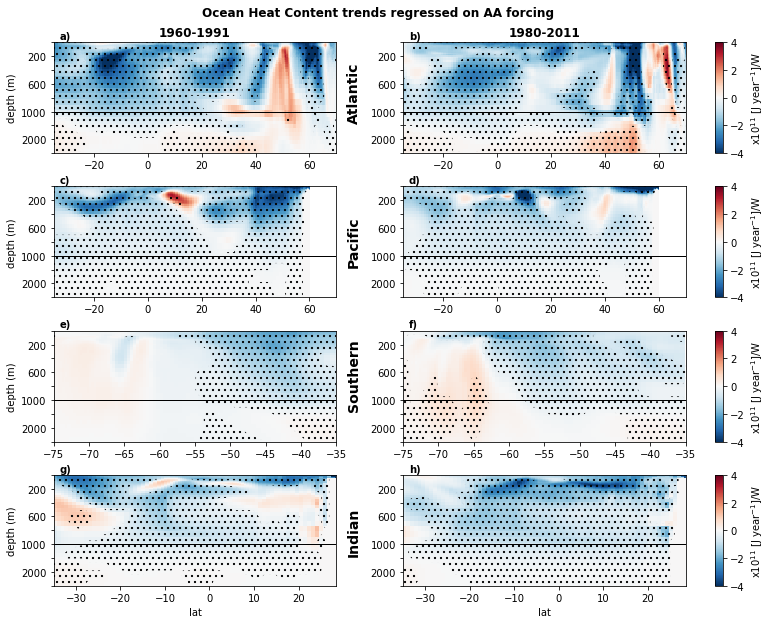

In [6]:
%matplotlib inline
fig, axes = plt.subplots(4, 4, gridspec_kw={'hspace':0.3,'wspace':0.2,'width_ratios':[1,0.03,1,0.03]},sharey='col',figsize=(12,10))

ip=0
for ib,basin in enumerate(['atl','pac','so','ind']):
    for it in range(0,2):
        ax=axes[ib,it*2]
        dplot_slope=slopes.sel(basin=basin).isel(time=it)        
        dplot_sig=sigs.sel(basin=basin).isel(time=it)    
        p1=dplot_slope.plot(x='lat',y='depth_alt',yincrease=False,
                add_colorbar=False,
                vmin=-clim,vmax=clim,
                cmap='RdBu_r',rasterized=True,ax=ax)         
        dplot_sig.plot.contourf(x='lat',y='depth_alt',alpha=0,levels=[-1,0,1],hatches=[None,'..'],
                                              add_colorbar=False,yincrease=False,ax=ax)
        ax.plot(latlims[basin],[2500,2500],'k',zorder=99,lw=1)
        
        ax.text(0.02,1.03,'{})'.format(chr(ord('a')+ip)),fontweight='bold',transform=ax.transAxes)

        if ib==0:
            ax.set_title(str(y_start[it])+'-'+str(y_end[it]),fontweight='bold')
        else:
            ax.set_title('')
        ax.set_xlim(latlims[basin][0],latlims[basin][1])   
        ax.set_ylim([4000,0])      
        ax.set_yticks([4000, 3500, 3000, 2500, 2000, 1500, 1000, 500, 0])
        ax.set_yticklabels(['',2000,'',1000,'', 600, '',200,''])
        if it == 0:
            ax.set(ylabel='depth (m)')
        else:
            ax.set(ylabel='')
            ax.text(-0.2,0.3,basin_name[basin],fontweight='bold',transform=ax.transAxes,rotation=90,fontsize=14)
            fig.colorbar(p1,cax=axes[ib,3],label='x10$^{11}$ [J year$^{-1}$]/W')
        if ib<3:
            ax.set(xlabel='')
        ip=ip+1
    axes[ib,1].set_visible(False)
        
plt.suptitle('Ocean Heat Content trends regressed on AA forcing',weight='bold',y=0.93)
plt.savefig(figs_dir+'Fig7_OHC_yz_regress_basins.png',bbox_inches='tight')